In [1]:
import numpy as np
import pandas as pd
import GCRCatalogs
from crow import mass_proxy
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy import stats

## Load the Catalog

In [2]:
t_halo = pd.read_parquet("./cosmodc2_with_richness.parquet")
data_table = t_halo
data_table = data_table[data_table['redshift'] >= 0.2]
data_table = data_table[data_table['redshift'] <= 1.0]
data_table = data_table[data_table['richness'] >= 20]
data_table = data_table[data_table['richness'] <= 200]


area = 439.78986

cluster_z = data_table["redshift"]
cluster_richness = np.log10(data_table["richness"])

bins_rich = np.log10([20,35,70,200])
bins_z = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
    cluster_z, cluster_richness, None, "count", bins=[bins_z, bins_rich]
)


## Compute Prediction For Fiducial Values

In [3]:
# Imports
import time
import pyccl as ccl

from crow import ClusterShearProfile
from crow import ClusterAbundance
from crow.recipes.binned_exact import ExactBinnedClusterRecipe
from crow.recipes.binned_grid import GridBinnedClusterRecipe
from crow import completeness_models, mass_proxy, purity_models, kernel
from crow.properties import ClusterProperty

# ---- Core cosmology and HMF (same numbers as your example) ----
hmf = ccl.halos.MassFuncDespali16(mass_def="200c")
m_pivot = 14.3
z_pivot = 0.5
cosmo = ccl.Cosmology(
    Omega_c=0.1109 / 0.71**2,
    Omega_b=0.02258 / 0.71**2,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    w0=-1.0,
    wa=0.0,
    transfer_function="boltzmann_camb"
)

# ---- Common grid / binning parameters for later cells ----
mass_grid_size = 80
redshift_grid_size = 40
proxy_grid_size = 40
sky_area = 440
mass_interval = (12.5, 15.0)


cl_abundandce = ClusterAbundance(cosmo, hmf)

In [4]:

z_bins = [(bins_z[i], bins_z[i+1]) for i in range(len(bins_z) -1)]
proxy_bins = [(bins_rich[i], bins_rich[i+1]) for i in range(len(bins_rich) - 1)]
redshift_distribution = kernel.SpectroscopicRedshift()
mass_richness = mass_proxy.MurataUnbinned(m_pivot, z_pivot)

mass_richness.parameters["mu0"] = 2.9337
mass_richness.parameters["mu1"] = 0.5899
mass_richness.parameters["mu2"] = 1.2911

mass_richness.parameters["sigma0"] = 0.3640
mass_richness.parameters["sigma1"] = 0.0543
mass_richness.parameters["sigma2"] = 0.0234

recipe_grid = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_abundandce,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_richness,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)
recipe_grid.setup()

grid_vals  = np.zeros((len(bins_z) -1,len(bins_rich) - 1))

for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        grid_vals[i,j]  = recipe_grid.evaluate_theory_prediction_counts(np.array(zb), np.array(pb), sky_area)
print(f"Counts Prediction: {grid_vals}\n")
print(f"Counts Data: {cluster_counts}")


Counts Prediction: [[142.56617186  22.40624827   0.93547525]
 [381.83660433  60.20664836   2.87971211]
 [665.40266227 100.9989833    4.97265786]
 [913.77064577 130.56066081   6.14732508]]

Counts Data: [[178.  16.   1.]
 [279.  42.   2.]
 [480.  91.   6.]
 [733. 138.  10.]]


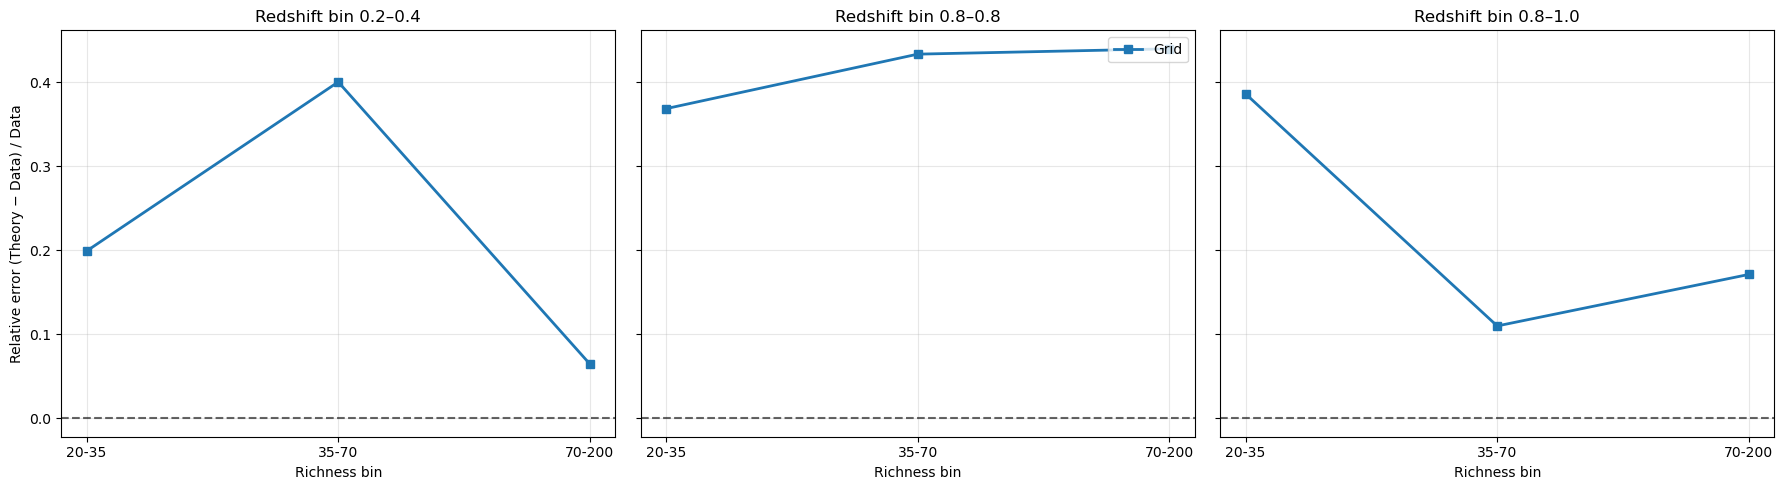

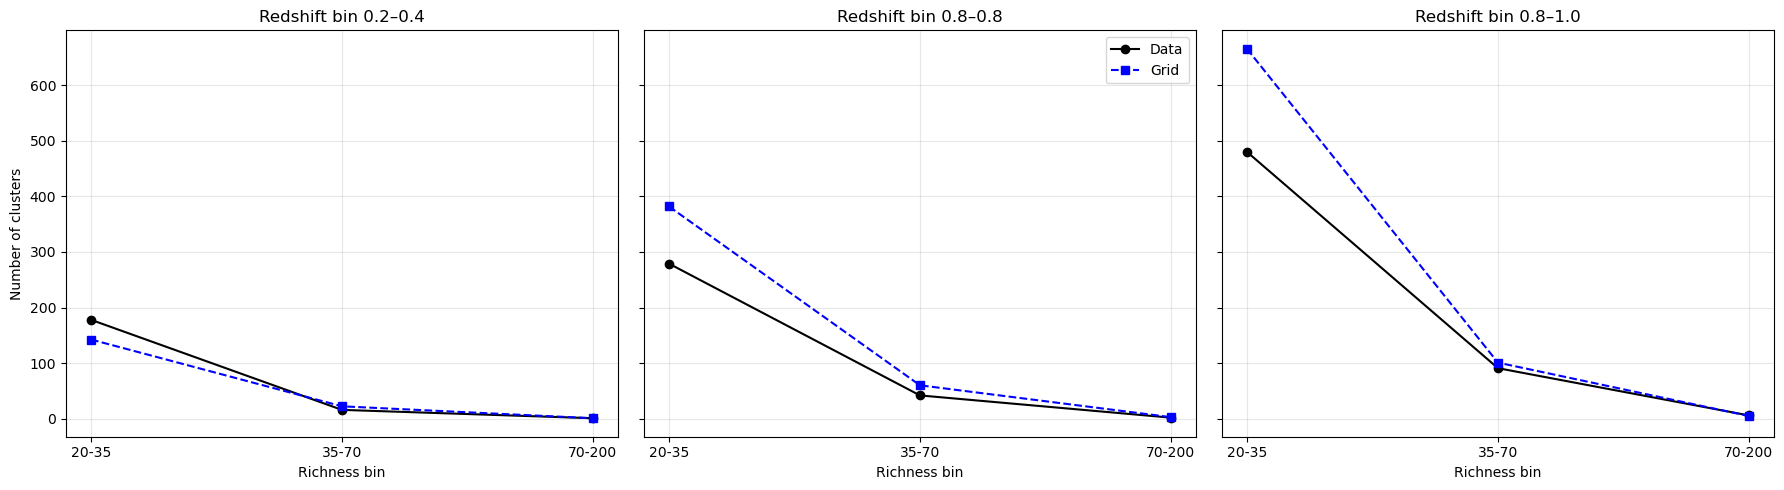

Computation versus data:


In [5]:
rel_err_grid  = abs((grid_vals  - cluster_counts) / cluster_counts)
z_labels = ['0.2–0.4', '0.8–0.8', '0.8–1.0']
rich_labels = ['20-35', '35-70', '70-200']
x = np.arange(len(bins_rich) - 1)  # richness bin index
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axes):
    ax.plot(x, rel_err_grid[i],  marker='s', lw=2, label='Grid')

    ax.axhline(0.0, color='k', linestyle='--', alpha=0.6)

    ax.set_title(f"Redshift bin {z_labels[i]}")
    ax.set_xticks(x)
    ax.set_xticklabels(rich_labels)
    ax.set_xlabel("Richness bin")

    ax.grid(alpha=0.3)

axes[0].set_ylabel("Relative error (Theory − Data) / Data")
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axes):
    ax.plot(x, cluster_counts[i], 'k-o', label='Data')
    ax.plot(x, grid_vals[i],  'b--s', label='Grid')

    ax.set_title(f"Redshift bin {z_labels[i]}")
    ax.set_xticks(x)
    ax.set_xticklabels(rich_labels)
    ax.set_xlabel("Richness bin")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Number of clusters")
axes[1].legend()

plt.tight_layout()
plt.show()
print("Computation versus data:")